# Method 1: Using Pystan

I'll do this for a single n, and treat the mode locations as fixed for now.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import lightkurve as lk
from astropy.units import cds
from astropy import units as u
import corner
import matplotlib
matplotlib.rc('xtick', labelsize=20)
matplotlib.rc('ytick', labelsize=20)
matplotlib.rc('axes',labelsize=20)


#The stellar parameters are for 16 Cyg A
nus = 0.411 #uHz
i = np.deg2rad(56.) #rad
d02 = 6.8 #uHz
dnu = 102. #uHz

In [2]:
locs = np.genfromtxt('locs.txt')
l0 = locs[int(np.floor(len(locs)/2)), 0]
l1 = locs[int(np.floor(len(locs)/2)), 1]
l2 = locs[int(np.floor(len(locs)/2)-1), 2]
l3 = locs[int(np.floor(len(locs)/2)-1), 3]
ff = np.genfromtxt('freqs.txt')
pp = np.genfromtxt('model.txt')

In [3]:
sel = [(ff >= l0 - 0.3*dnu) & (ff <= l0 + 0.7*dnu)]
f = ff[tuple(sel)]
p = pp[tuple(sel)] 

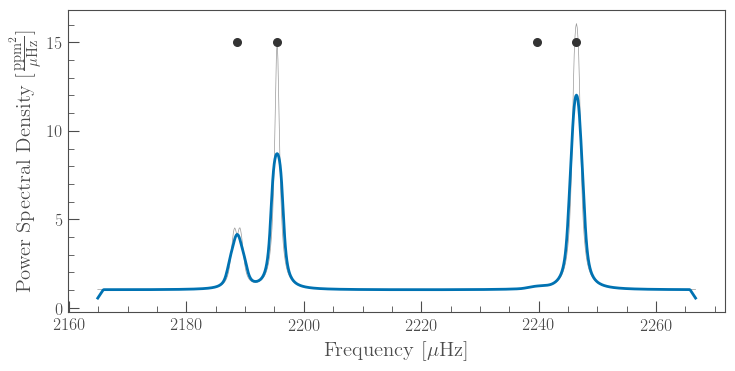

In [5]:
pg = lk.Periodogram(f*u.microhertz, p*(cds.ppm**2/u.microhertz))
ax = pg.plot(alpha=.5)
pg.smooth(filter_width=2.).plot(ax=ax, linewidth=2)
plt.scatter([l0,l1,l2,l3],[15,15,15,15],s=30)
plt.show()

Lets fit a group of lorentzians to these data!

In [7]:
import pystan
model = '''
functions{      
    real lorentzian(real loc, int l, int m, real f, real eps, real H, real w, real nus){
        return (eps * H) ./ (1 + (4/w^2) * (f - loc + m*nus)^2);
    }

    real[] multiplets(int N, real[] locs, real[] f, matrix eps, real[] H, real[] w, real nus){
        real mod[N]; 
        mod = rep_array(1., N);   // Give the model a fixed background of 1.
        
        for (l in 0:3){           // Iterate over all l in a given n
            for (m in -l:l){      // Iterate over all m in a given l
                for (n in 1:N){   // Generate the value of a lorentzian for this l and m at a given f
                    mod[n] += lorentzian(locs[l+1], l, m, f[n], eps[l+1,abs(m)+1], H[l+1], w[l+1], nus);
                }
            }
        }
        return mod;
    }
}
data{
    int N;            // Number of data points
    int M;            // Number of modes
    real f[N];        // Frequency
    real p[N];        // Power
    real asy_locs[M]; // Mode locations (this will have to change for multiple n modes)
}
parameters{
    real logAmp[M];      // Mode amplitude in log space
    real logGamma[M];    // Mode linewidth in log space
    real locs[M];        // True mode locations
    real<lower=0> vsini; // Line of sight rotational frequency
    real<lower=0> nus;   // Rotational frequency splitting
}
transformed parameters{
    real i;          // Angle of inclination (rad)
    real H[M];       // Mode height
    real w[M];       // Mode linewidth
    matrix[4,4] eps; // Matrix of legendre polynomials
    eps = rep_matrix(i, 4, 4);
     
    i = asin(vsini / nus); // Transform angle of inclination from line of sight rotation frequency
    for (m in 1:M){
        w[m] = 10^logGamma[m];             // Transform mode linewidth from log space
        H[m] = 10^logAmp[m] / pi() / w[m]; // Transform mode amplitude to mode height
    }
    
    // Now I'll calculate all the legendre polynomials for this i
    eps[0+1,0+1] = 1.;
    eps[1+1,0+1] = cos(i)^2;
    eps[1+1,1+1] = 0.5 * sin(i)^2;
    eps[2+1,0+1] = 0.25 * (3. * (i)^2 - 1.)^2;
    eps[2+1,1+1] = (3./8.)*sin(2*i)^2;
    eps[2+1,2+1] = (3./8.) * sin(i)^4;
    eps[3+1,0+1] = (1./64.)*(5.*cos(3.*i) + 3.*cos(i))^2;
    eps[3+1,1+1] = (3./64.)*(5.*cos(2.*i) + 3.)^2 * sin(i)^2;
    eps[3+1,2+1] = (15./8.)*cos(i)^2 * sin(i)^4;
    eps[3+1,3+1] = (5./16.)*sin(i)^6;
    
}
model{
    real modes[N];

    modes = multiplets(N, locs, f, eps, H, w, nus);
    modes ~ normal(p, 0.1);  // This will eventually have to be expanded to deal with Chi^2dof noise
    
    //priors on the parameters
    logAmp ~ normal(1, 1);
    logGamma ~ normal(0, 0.1);
    locs ~ normal(asy_locs, 1);
    i ~ uniform(0.1, pi()/2);
    nus ~ normal(0.411, 0.1);
}
'''
sm = pystan.StanModel(model_code=model)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_95838d74eb731b601156ddd5af93413d NOW.


In [9]:
data = {'N':len(f),
        'M': 4,
        'f':f,
        'p':p,
        'asy_locs':[l0,l1,l2,l3]}

init = {'logAmp' :   np.ones(4),
        'logGamma' : np.zeros(4),
        'vsini':nus*np.sin(i),
        'nus':nus,
        'locs' : [l0, l1, l2, l3]}

In [10]:
nchains = 4
fit = sm.sampling(data=data, iter=1000, chains=nchains, init = [init for n in range(nchains)])

In [11]:
print(fit)

Inference for Stan model: anon_model_95838d74eb731b601156ddd5af93413d.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

              mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
logAmp[1]     1.64  3.6e-5 1.8e-3   1.64   1.64   1.64   1.64   1.65   2509    1.0
logAmp[2]     1.81  3.4e-5 1.5e-3   1.81   1.81   1.81   1.82   1.82   1902    1.0
logAmp[3]     1.23  2.0e-4 8.8e-3   1.21   1.22   1.23   1.23   1.24   1879    1.0
logAmp[4]    -0.09  2.9e-3    0.1  -0.31  -0.15  -0.08  -0.02   0.08   1224    1.0
logGamma[1] 4.1e-4  4.8e-5 2.5e-3-4.6e-3-1.2e-3 4.1e-4 2.1e-3 5.4e-3   2723    1.0
logGamma[2]  -0.01  1.2e-4 4.3e-3  -0.02  -0.01  -0.01-8.8e-3-2.8e-3   1382    1.0
logGamma[3] 9.8e-3  4.6e-4   0.02  -0.02-9.6e-4 9.9e-3   0.02   0.04   1303    1.0
logGamma[4]   0.02  2.4e-3    0.1  -0.18  -0.04   0.02   0.09   0.21   1626    1.0
locs[1]     2195.4  4.0e-5 2.1e-3 2195.4 2195.4 2195.4 2195.4 2195

/home/oliver/.local/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
/home/oliver/.local/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.


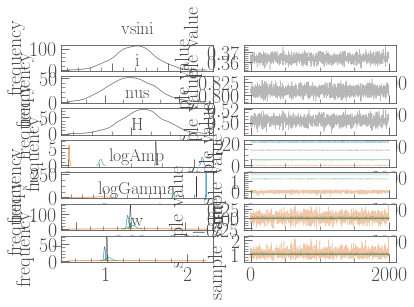

In [12]:
fit.plot(pars=['vsini','i','nus','H','logAmp','logGamma','w'])
plt.show()

In [13]:
truths= [init['vsini'],14., np.nan,init['nus']]

INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.


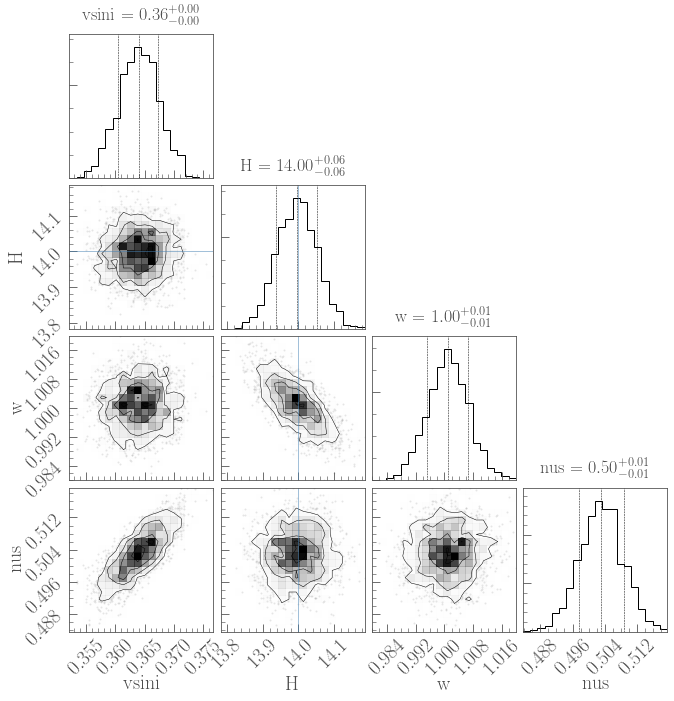

In [14]:
labels=['vsini','H','w','nus']
chain = np.array([fit[labels[0]], fit[labels[1]].T[0], fit[labels[2]].T[0], fit[labels[3]]])
corner.corner(chain.T, labels=labels, quantiles=[0.16, 0.5, 0.84],
            truths=truths,show_titles=True)
plt.show()

In [15]:
def get_epsilon(i, l, m):
#I use the prescriptions from Gizon & Solank 2003 and Handberg & Campante 2012
    if l == 0:
        return 1
    if l == 1:
        if m == 0:
            return np.cos(i)**2
        if np.abs(m) == 1:
            return 0.5 * np.sin(i)**2
    if l == 2:
        if m == 0:
            return 0.25 * (3 * np.cos(i)**2 - 1)**2
        if np.abs(m) ==1:
            return (3/8)*np.sin(2*i)**2
        if np.abs(m) == 2:
            return (3/8) * np.sin(i)**4
    if l == 3:
        if m == 0:
            return (1/64)*(5*np.cos(3*i) + 3*np.cos(i))**2
        if np.abs(m) == 1:
            return (3/64)*(5*np.cos(2*i) + 3)**2 * np.sin(i)**2
        if np.abs(m) == 2:
            return (15/8) * np.cos(i)**2 * np.sin(i)**4
        if np.abs(m) == 3:
            return (5/16)*np.sin(i)**6
    
def lorentzian(f, l, m, loc, i, H, w, nus):
    eps = get_epsilon(i,l,m)
    model = eps * H / (1 + (4/w**2)*(f - loc + m * nus)**2)
    return model

model = np.ones(len(f))
i = np.median(fit['i'])
nus = np.median(fit['nus'])
for l in np.arange(3+1):
    for m in range(-l, l+1):
        loc = np.median(fit['locs'].T[l])
        H = np.median(fit['H'].T[l])
        w = np.median(fit['w'].T[l])
        model += lorentzian(f, l, m, loc, i, H, w, nus)

INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
/home/oliver/.local/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.


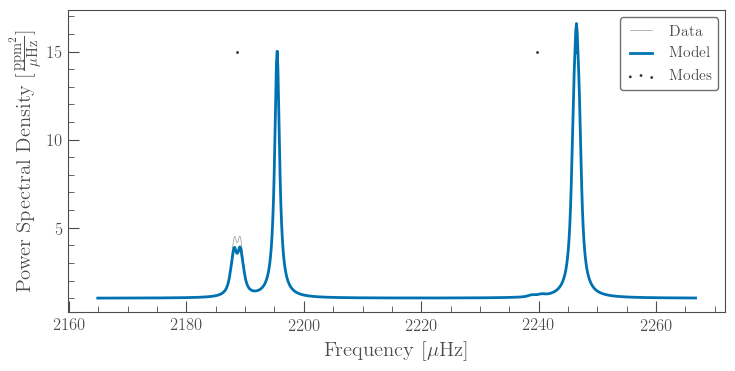

In [16]:
pg = lk.Periodogram(f*u.microhertz, p*(cds.ppm**2/u.microhertz))
ax = pg.plot(alpha=.5, label='Data')
plt.scatter([l0,l1,l2,l3],[15,15,15,15], label='Modes', s= 10)
plt.plot(f, model, linewidth=2, label='Model')
plt.legend()